# Question 1

In [2]:
import numpy as np
import pandas as pd

#Define function to run trials - made so that more teams can easily be added.
# lamdict = dictionary in "Team": Team Expected Goals format, num_of_trials = number of trials, teams_to_compare = list of two teams to compare.
def run_trials(lamdict, num_of_trials = 1000, teams_to_compare = ("A","B")):
    trial_data_dict = pd.DataFrame(columns = ["Outcome"]) #Initialise Empty df
    count_wins = 0 #Initialise number of games won by team1
    for value in lamdict.values(): 
        for key in lamdict:
            trial_data_dict[key] = np.random.poisson(value, num_of_trials)
    outcomes = [] #Initialise list
    for i in range(num_of_trials):
        team1 = teams_to_compare[0]
        team2 = teams_to_compare[1]
        if trial_data_dict[team1].iloc[i] > trial_data_dict[team2].iloc[i]:
            outcome = team1
            count_wins += 1
        elif trial_data_dict[team1].iloc[i] == trial_data_dict[team2].iloc[i]:
            outcome = "D"
        else:
            outcome = team2
        outcomes.append(outcome)
    trial_data_dict["Outcome"] = outcomes
    proportion_of_wins = count_wins/num_of_trials
    percentage_of_wins = proportion_of_wins*100

    print(f" In a Monte Carlo Simulation with {num_of_trials} trials, Team {team1} won {percentage_of_wins:.2f}% of games against Team {team2}.")
    return trial_data_dict
           

#Execution
lamdict = {"A": 1.5, "B": 2}
teams_to_compare = ("A","B")
run_trials(lamdict, 1000, teams_to_compare)



 In a Monte Carlo Simulation with 1000 trials, Team A won 37.30% of games against Team B.


,Outcome,A,B
0,D,1,1
1,A,5,0
2,B,2,4
3,D,1,1
4,A,3,0
...,...,...,...
995,A,2,1
996,B,1,4
997,A,2,0
998,D,2,2


# Question 2
Plan on this one is to generate the opponents first, store them in a list and then use run_trials to simulate the matchup. Using a set for used teams will be helpful since it does not create duplicates.

In [4]:
import numpy as np
import pandas as pd
import random 
#Setting a random seed for:
np.random.seed(30) #numpy
random.seed(30) #python

#Define function to run trials - made so that more teams can easily be added.
# lamdict = dictionary in "Team": Team Expected Goals format, num_of_trials = number of trials, teams_to_compare = list of two teams to compare.
def run_trials(lamdict, match_ups, num_of_trials = 1):
    match_outcomes = [] #Initialise Empty df
    teams = set()
    for teamA, teamB in match_ups: #Gathering Unique Team Names 
        teams.update([teamA, teamB])
    total_goals_per_team = {team: 0 for team in teams}
    number_of_appearances = {team: 0 for team in teams}
    for teamA, teamB in match_ups:
        teamA_goals = int(np.random.poisson(lamdict[teamA], num_of_trials))
        teamB_goals = int(np.random.poisson(lamdict[teamB], num_of_trials))
        match_outcomes.append({"TeamA": teamA, "TeamB":teamB, "GoalA": teamA_goals, "GoalB": teamB_goals})
        total_goals_per_team[teamA] += teamA_goals
        total_goals_per_team[teamB] += teamB_goals
        number_of_appearances[teamA] += 1
        number_of_appearances[teamB] += 1
    mean_goals = {team: total_goals_per_team[team]/number_of_appearances[team] for team in total_goals_per_team}
    match_outcomes_df = pd.DataFrame(match_outcomes)
    print(f"Our simulated matches looked like this:\n{match_outcomes_df.to_string(index= False)}")
    for team, mean_goal in mean_goals.items():
            print(f"Team {team} scored {mean_goal:.1f} goals.")

    return match_outcomes_df, total_goals_per_team, number_of_appearances, mean_goals

def select_teams(lamdict, num_of_matches):
    teams = list(lamdict.keys())
    matches = []
    used_teams = set()
    while len(used_teams) < len(teams):
        team1, team2 = random.sample(teams, 2)
        if team1 not in used_teams or team2 not in used_teams:
            used_teams.update([team1, team2])
            matches.append((team1, team2))
    while len(matches) < num_of_matches:
        team1, team2 = random.sample(teams, 2)
        matches.append((team1, team2))
    return matches, teams



#Execution
lamdict = {"W": np.e**1, "X": np.e**0.5, "Y": np.e**0.75, "Z": np.e**1.25}
num_of_matches = 10
match_ups, teams = select_teams(lamdict, num_of_matches)
match_outcomes, total_goals_per_team, number_of_appearances, mean_goals = run_trials(lamdict, match_ups)

Our simulated matches looked like this:
TeamA TeamB  GoalA  GoalB
    Y     Z      3      5
    W     Y      2      2
    X     Z      2      4
    W     X      3      0
    Z     Y      5      3
    X     W      1      2
    Z     W      4      0
    X     W      2      5
    W     Z      3      6
    Z     Y      3      0
Team Y scored 2.0 goals.
Team X scored 1.2 goals.
Team Z scored 4.5 goals.
Team W scored 2.5 goals.


/var/folders/xw/rtnxpqfs5x1c24fnd80jdymh0000gn/T/ipykernel_35442/4221264330.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  teamA_goals = int(np.random.poisson(lamdict[teamA], num_of_trials))
/var/folders/xw/rtnxpqfs5x1c24fnd80jdymh0000gn/T/ipykernel_35442/4221264330.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  teamB_goals = int(np.random.poisson(lamdict[teamB], num_of_trials))


# Question 4

In [6]:
import scipy.optimize as opt
from scipy.stats import poisson


def process_data(match_outcomes, teams):
    # Initialize a dictionary with teams as keys and empty lists as values
    team_goals_per_match = {team: [] for team in teams}
    
    # Iterate over rows of the DataFrame
    for _, row in match_outcomes.iterrows():
        # Extract values for TeamA, TeamB, GoalA, and GoalB
        TeamA, TeamB, GoalA, GoalB = row['TeamA'], row['TeamB'], row['GoalA'], row['GoalB']
        
        # Append scores to the corresponding teams
        team_goals_per_match[TeamA].append(GoalA)
        team_goals_per_match[TeamB].append(GoalB)
    
    return team_goals_per_match
        

# Log likelihood with input log transformed (avoids optimiser going out of range)
# Output transformed by multiplying by minus 1 (means minimising finds mle)
def loglike_inc_trans(psi, D): 
    myL = np.exp(psi)
    s = np.sum(poisson.logpmf(D, myL))
    s_trans = -1 * s
    return s_trans    

# Real code should probably repeatedly reoptimise
def obtain_and_print_estimates_and_AICc(match_outcomes, teams, num_of_matches):
    processed_data = process_data(match_outcomes, teams)
    max_loglikehoods = 0
    k = 0 #Number of Parameters
    N = num_of_matches # Total Number of matches
    for team in teams:
        k += 1
        w = opt.minimize(fun=loglike_inc_trans, x0=1.5, args=processed_data[team]) #In fact maximising since we inverted our function by multiplying by -1
        if w.success:
            max_loglikehoods += (-1*w.fun) #Summing LogLikehoods for different parameters - unconventional approach I know but it works well.
            psi = w.x[0]
            myL = np.exp(psi) # Undoing transformation
            print(f"lambda{team}={myL:.2f}")
        else:
            print("Optimisation failed") 
    print(f"Max Log Likelihood={max_loglikehoods:.2f}")
    AICc = 2*k - 2*(max_loglikehoods) + (2*k*(k+1))/(N-k-1)
    print(f"AICc = {AICc}")

obtain_and_print_estimates_and_AICc(match_outcomes, teams, num_of_matches)


lambdaW=2.50
lambdaX=1.25
lambdaY=2.00
lambdaZ=4.50
Max Log Likelihood=-33.71
AICc = 83.41404291575007


# Question 5


In [8]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Function to reformat the data in the required shape for the run_glm_and_print_stats function.
def make_stacked_data(match_outcomes):
    # Concatenate the Team and Goal columns into a single column using .concat 
    stacked_df = pd.concat([
        match_outcomes[["TeamA", "GoalA"]].rename(columns={"TeamA": "Team", "GoalA": "Goals"}),
        match_outcomes[["TeamB", "GoalB"]].rename(columns={"TeamB": "Team", "GoalB": "Goals"})
    ])
    stacked_df.reset_index(drop = True)
    return stacked_df
#Function to run GLM and print the associated statistics, including an option to print the summary.
def run_glm_and_print_stats(match_outcomes, print_summary):
    # Running Generalised Linear Model Regression using stacked df as input, fitting to a poisson distribution.
    GLM = smf.glm(formula = 'Goals ~ Team',
     data = make_stacked_data(match_outcomes),
     family = sm.families.Poisson()).fit()
    if print_summary:
        print(GLM.summary())
    else:
        pass
    
    #The intercept is the log of the lambda parameter, hence I need to exponentiate it. Similarly, I need to normalise the coefficients of the other teams using the intercept and then exponentiate them as well.
    #Extracting and printing lambdas
    params = GLM.params
    lamdict = {}
    for team in teams:
        if team == "W":
            lamdict[team] = np.exp(params["Intercept"])
        else:
            lamdict[team] = np.exp(params["Intercept"] + params[f"Team[T.{team}]"])
    # Now print results in one place
    print("Generalised Linear Model Regression using stacked df as input, fitting to a poisson distribution produces the following lambdas:")
    for team in teams:
        print(f"Lambda{team} = {lamdict[team]:.2f}")
    #Extracting and printing AIC, converting to AICc, and Max Log likehood.
    max_log_likehood = GLM.llf  # log-likelihood at the fit
    k = len(params)
    N = num_of_matches
    AICc = GLM.aic + (2*k*(k+1))/(N-k-1)
    print(f"Max Log Likehood: {max_log_likehood:.2f}\nAICc: {AICc:.2f}")
    return GLM, lamdict, max_log_likehood, AICc
#Execution
GLM, lamdict, max_log_likehood, AICc = run_glm_and_print_stats(match_outcomes, False)

Generalised Linear Model Regression using stacked df as input, fitting to a poisson distribution produces the following lambdas:
LambdaW = 2.50
LambdaX = 1.25
LambdaY = 2.00
LambdaZ = 4.50
Max Log Likehood: -33.71
AICc: 83.41


# Question 6

Alpha = 1.89 and Beta = -0.43
Max Log Likehood: -33.87
AICc: 73.46


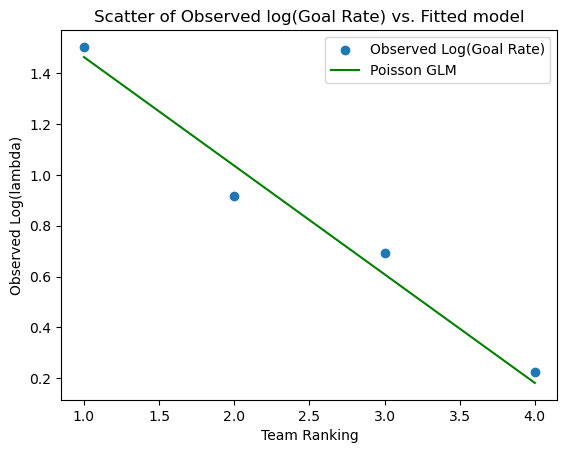

When we individually parametrise each team's goal rate we end up with 4 parameters and an AICc of roughly 80-90.
However using a GLM we are able to reduce the model's parameters to 2 (just alpha and beta), this also leads to a reduced AICc, generally in the 60-80 range. Hence the GLM is the more parsimonious option.


In [10]:
import matplotlib.pyplot as plt
#Function to reformat the data in the required shape for the run_glm_and_print_stats function, this time with Rank as a column.
def make_stacked_data_with_rank(match_outcomes, rankdict):
    # Concatenate the Team and Goal columns into a single column using .concat 
    stacked_df = pd.concat([
        match_outcomes[["TeamA", "GoalA"]].rename(columns={"TeamA": "Team", "GoalA": "Goals"}),
        match_outcomes[["TeamB", "GoalB"]].rename(columns={"TeamB": "Team", "GoalB": "Goals"})
    ])
    stacked_df.reset_index(drop = True)
    stacked_df["Rank"] = stacked_df["Team"].map(rankdict)
    return stacked_df
    
#Function to run GLM and print the associated statistics, including an option to print the summary.
def run_glm_plus_print_and_plot(match_outcomes, print_summary):
    # Running Generalised Linear Model Regression using stacked df as input, fitting to a poisson distribution.
    GLM = smf.glm(formula = 'Goals ~ Rank',
     data = make_stacked_data_with_rank(match_outcomes, rankdict),
     family = sm.families.Poisson()).fit()
    if print_summary:
        print(GLM.summary())
    else:
        pass
    #Extracting and alpha hat and beta hat
    params = GLM.params
    alpha = params["Intercept"]
    beta = params["Rank"]
    print(f"Alpha = {alpha:.2f} and Beta = {beta:.2f}")
    #Extracting and printing AIC, converting to AICc, and Max Log likehood.
    max_log_likehood = GLM.llf  # log-likelihood at the fit
    k = len(params)
    N = num_of_matches
    AICc = GLM.aic + (2*k*(k+1))/(N-k-1)
    print(f"Max Log Likehood: {max_log_likehood:.2f}\nAICc: {AICc:.2f}")
    return GLM, max_log_likehood, AICc, alpha, beta
    
# Function to plot scatter and linegraph    
def plot_line_and_scatter(alpha, beta, rankdict, lamdict):
    #Bearing in mind log (𝜆𝑘) = 𝛼 + 𝛽𝑟𝑘
    obs_log_lam = np.log(list(lamdict.values()))
    r_range = np.linspace(1,4,1000)
    line = alpha + beta*(r_range)
    plt.scatter(rankdict.values(), obs_log_lam, label = "Observed Log(Goal Rate)")
    plt.plot(r_range, line, color = "Green", label = "Poisson GLM")
    plt.xlabel("Team Ranking")
    plt.ylabel("Observed Log(lambda)")
    plt.title('Scatter of Observed log(Goal Rate) vs. Fitted model')
    plt.legend()
    plt.show()

#Execution
rankdict = {"W": 2, "X": 4, "Y": 3, "Z": 1} #Redoing lamdict to store ranking rather than lambda
GLM, max_log_likehood, AICc, alpha, beta = run_glm_plus_print_and_plot(match_outcomes, False)
plot_line_and_scatter(alpha, beta, rankdict, lamdict)
print("When we individually parametrise each team's goal rate we end up with 4 parameters and an AICc of roughly 80-90.\nHowever using a GLM we are able to reduce the model's parameters to 2 (just alpha and beta), this also leads to a reduced AICc, generally in the 60-80 range. Hence the GLM is the more parsimonious option.")

# Question 7

In [12]:
import os
#Config
data_dir = "../Data"
team_and_rank_path = os.path.join(data_dir, "2024_rankings.csv")
team_and_rank = pd.read_csv(team_and_rank_path)
#Function to estimate lambda (AKA goal rate).
def est_goal_rate(alpha, beta, rank):
    return np.exp(alpha + beta*rank)

def run_one_game(team_and_goal_rate, narrate = False): #Uses the shuffle_reformat_play function in order to plan out and play matches. Input argument must be a dataframe.

    # Shuffles teams to ensure that all teams can get byes.
    current_round = shuffle_reformat_play(team_and_goal_rate, reformat=False, play=False)

    # Defines the number of winners needed in each round (16 in the first since 8 winners + 8 byes) and use this to determine what round number it is.
    number_of_rounds = 5 
    for i in range(number_of_rounds):  # Keeping count of rounds
        if i == 0:  # First round has byes so must be treated differently
            first_round_winners = shuffle_reformat_play(current_round[:16])  # Use round size to take correct sample size
            first_round_byes = current_round[16:24]  # Next 8 teams as byes
            if narrate:
                #Fixing up df text so it looks pretty in a string.
                winners_list = ", ".join(first_round_winners["Team"].tolist())
                print(f"The following teams win their first round matches:\n{winners_list}")
                byes_list = ", ".join(first_round_byes["Team"].tolist())
                print(f"The following teams have 1st round byes:\n{byes_list}")
            # Format df for round 2
            current_round = pd.concat([first_round_winners, first_round_byes], ignore_index=True)
        else:
            # No logic needed for further rounds
            current_round = shuffle_reformat_play(current_round)
            if i == 1 and narrate:
                #Fixing up df text so it looks pretty in a string.
                winners_list = ", ".join(current_round["Team"].tolist())
                print(f"The following teams win 2nd round matches:\n{winners_list}")
            if i == 2 and narrate:
                print(f"{current_round.iloc[0]['Team']}, {current_round.iloc[1]['Team']}, {current_round.iloc[2]['Team']}, and {current_round.iloc[3]['Team']} are through the quarters.")
            if i == 3 and narrate:
                print(f"{current_round.iloc[0]['Team']} and {current_round.iloc[1]['Team']} proceed to the final... suspense is building...")
            if i == 4 and narrate:
                winner_name = current_round.iloc[0]['Team']
                if winner_name == "England":
                    print(f"{winner_name} win the final!! Harry Kane should be knighted!")
                else:
                    print(f"{winner_name} win the euros. Commence 3 days of national mourning.")
        winner_name = current_round.iloc[0]["Team"]

    return winner_name

#This function basically combines three functions, shuffle teams, reformat into a df with teams that play eachother, and then playing the games.
def shuffle_reformat_play(round_teams, shuffle = True, reformat = True, play = True): #Round Teams can be in any dataframe, the remaining arugments determine function(s) of the program.
    if shuffle:
        round_teams = round_teams.sample(frac=1).reset_index(drop=True)
    if reformat:
        # Create match up df using list comprehensioin - syntax = [expression for item in iterable if condition]
        round_teams = pd.DataFrame([
            {"Team A": round_teams.iloc[i]["Team"],
                "Goal Rate A": round_teams.iloc[i]["Goal Rate"],
                "Team B": round_teams.iloc[i + 1]["Team"],
                "Goal Rate B": round_teams.iloc[i + 1]["Goal Rate"],
            }
            for i in range(0, len(round_teams), 2)])
    if play:
        # Initialise winners list to keep track of who wins
        round_winners = []
        # Loop through fixtures
        for _, row in round_teams.iterrows():
            teamA = row["Team A"]
            muA = row["Goal Rate A"]
            teamB = row["Team B"]
            muB = row["Goal Rate B"]

            #Simulate goals
            teamA_goals = np.random.poisson(muA)
            teamB_goals = np.random.poisson(muB)

            # Logic to determine winner
            if teamA_goals > teamB_goals:
                winner = {"Team": teamA, "Goal Rate": muA}
            elif teamB_goals > teamA_goals:
                winner = {"Team": teamB, "Goal Rate": muB}
            else:  # When there's a draw
                random_choice = np.random.choice([0, 1]) #Logic to pick between teamA and teamB at random
                if random_choice == 0:
                    winner = {"Team": teamA, "Goal Rate": muA}
                else:
                    winner = {"Team": teamB, "Goal Rate": muB}

            #Making round_winners into a dataframe and adding winner
            round_winners.append(winner)
            round_teams = pd.DataFrame(round_winners)
    return round_teams


    
def calc_winning_prob(round_teams, sample_size, narrate):
    # Create df with Team and No of wins column - initialise no of wins column to 0.
    team_wins = pd.DataFrame({"Team": round_teams["Team"],"No. of Wins": 0})
    for _ in range(sample_size):
        winner = run_one_game(round_teams, narrate)
        team_wins.loc[team_wins["Team"] == winner, "No. of Wins"] += 1
    team_wins["Winning Probability"] = team_wins["No. of Wins"]/sample_size
    team_wins = team_wins.sort_values(by="Winning Probability", ascending=False).reset_index(drop=True)
    print(f"After Running {sample_size} simulations we get these results:")
    print(team_wins)
    return team_wins

#execution
alpha = 1
beta = -0.05
team_and_rank["Goal Rate"] = team_and_rank["Rank"].apply(lambda rank: est_goal_rate(alpha, beta, rank))
team_and_rank.drop('Rank', axis=1, inplace=True)
run_one_game(team_and_rank, True)
team_wins = calc_winning_prob(team_and_rank, 1000, False)

The following teams win their first round matches:
Slovakia, Switzerland, Portugal, Spain, Italy, Turkey, Denmark, Serbia
The following teams have 1st round byes:
Germany, Belgium, Netherlands, Czech Republic, England, Croatia, Slovenia, Romania
The following teams win 2nd round matches:
Belgium, Germany, Croatia, Spain, Netherlands, Italy, Denmark, Switzerland
Switzerland, Croatia, Netherlands, and Italy are through the quarters.
Italy and Croatia proceed to the final... suspense is building...
Italy win the euros. Commence 3 days of national mourning.
After Running 1000 simulations we get these results:
              Team  No. of Wins  Winning Probability
0          Belgium          184                0.184
1           France          182                0.182
2          England          147                0.147
3         Portugal          108                0.108
4      Netherlands           94                0.094
5            Spain           75                0.075
6          Croat